## The puzzle

At the IBM-Prague Thanksgiving gathering, my colleague Borek's daughter was playing with a nice puzzle: A 5x5 board on which you stack 12 shapes made of connected balls into a pyramid.  The 55 balls that make up the shape pile nicely into a pyramid 5 levels high.  There's also a different 5x11 board where the same pieces need to fit together in a plane.

Some pictures are here http://www.smartgames.eu/en/smartgames/iq-puzzler and a video below.

In [7]:
from IPython.display import IFrame
# Youtube
IFrame('https://www.youtube.com/embed/xL5rYrF8Dck?rel=0&amp;&amp;showinfo=0',width="560",  height="420")


## The problem and outline of a solution
This got Borek and I thinking if we can solve this with a computer.  The problem reduces to finding an [exact cover](https://en.wikipedia.org/wiki/Exact_cover) of the board (the 55 slots in the 5x5 pyramid or the 11x5 rectangle).  The cover candidates are the 12 pieces, in all possible positions (orientations and translations) that intersect and are contained in the board.  

If we enumerate all the slots in the board, a single positioned piece can be represented as boolean 1x55 vecor, with ones for the slots where the piece is present, and zeros elsewhere.  We also need to keep track of the identity of the piece, because we cannot use the same piece in multiple positions.  So we extend the 1x55 vector with 12 more columns (to make a 1x67 vector).  If we are using the $i$th piece, we will set the $55+i$th element to 1, and the remaining added 11 elements to 0.  

Now we can list all M cover candidates as rows in a Mx67 matrix.  Solving the problem reduces to finding a subset of rows of the matrix, such that the sum of each column in the subset is exactly one.

The exact cover problem is a [somewhat famous](https://en.wikipedia.org/wiki/Karp%27s_21_NP-complete_problems) [NP-complete](https://en.wikipedia.org/wiki/P_versus_NP_problem) problem.  Donald Knuth described an elegant implementation of the exact cover search on sparse matrices (such as our M) which he called [dancing links](https://arxiv.org/abs/cs/0011047). [Various](https://github.com/DavideCanton/DancingLinksX) [implementations](https://github.com/mharrys/sudoku) of dancing links exist on github.  We use one of the pure-python permissive-license ones to solve the problem, given M.

As I was writing this up, I found a very nice description of [solving the planar board puzzle](http://www.ams.org/samplings/feature-column/fcarc-kanoodle) from 2009, with dancing links.  (The key idea is the same for the pyramid board as well).

## A coordinate system for the board and positioned pieces
It is natural to represent the planar 5x11 board as integer coordinates in 2D.  

For the pyramid board, it's more convenient to chose a non-orthonormal basis $B$, such that the board slots and the balls of positioned pieces still fall on integer coordinates in that basis. One possibility is the basis
$$
B = \left\{
\begin{bmatrix}
         1\\
         0\\
         0\\
\end{bmatrix}
,
\begin{bmatrix}
         0\\
         1\\
         0\\
\end{bmatrix}
,
\begin{bmatrix}
         \frac{1}{2}\\
         \frac{1}{2}\\
         \frac{\sqrt{2}}{2}\\
\end{bmatrix}
\right\}
$$

The pyramid way of arranging the balls is called "cubic closed packed". It is one of the two ways of [packing equal sized spheres as closesly as possible](https://en.wikipedia.org/wiki/Close-packing_of_equal_spheres).  

The other (equally dense) way to pack the spheres is called "hexagonal close-packed".  Arranging the balls in that way would be a different puzzle.  This arrangement doesn't have a linear basis which would map the board slots to an orthogonal ineger grid.

## Finding all positioned pieces
How do we find all the positioned pieces from the 12 pieces so we can build the Mx67 cover matrix? (Remember, a positioned piece is a rotated, translated piece that is fully contained in the board).  We first find all the legal rotations of a piece in the real-world basis.  We then change it's coordinate system to the convenient basis $B$ we described above.  In that coordinate system, for each rotation we can:
1. Sanity-check that our rotation was legal (it is legal if the piece coordinates are integers in the grid space).
1. Translate the rotated piece to every possible position within the bounding box of the board.  Only those translations that place the piece fully inside the board are the valid positioned pieces. 

So the only remaining question is:
### Which rotations are valid?

#### The planar 5x11 planar board case
For the planar board (in the X-Y plane), it's obvious that the legal rotations are around the Z axis by $90^{\circ}$ 0,1,2 or 3 times, plus "the flip" which is a rotation around the Y axis by $180^{\circ}$ 0 or 1 times.  And in this case, the rotations commute which is not true in general for 3D rotations. ('commute' means that the rotations and flips can be reordered without changing the outcome).  So we only need to consider 2x8 different rotations for each piece.  If the piece happens to be symmetric, some rotations give us the same shape, and we can remove duplicates (e.g. a square piece has only a single orientation after the duplicates have been removed).

Following the above algorithm, it turns out that starting from the 12 given puzzle pieces, there are M=1789 positioned pieces on the planar board, and we are dealing with 1789x67 cover matrix.

#### The pyramid board case
Finding the legal rotations in this case gets more complicated and this is the part that I understand the least about solving the puzzle.  I will write down what I know.

I think the systematic way to generate all rotations has to do with [crystallographic point groups](https://en.wikipedia.org/wiki/Crystallographic_point_group).  But this seems to be a large area of mathematics that I didn't want to pursue just for this problem.  We can try to find all the valid rotations in an ad hoc way.

Imagine the slots in the pyramid board extended by translation to inifinty in all directions. The valid rotations are the ones that map to the slot locations to other slot locations.  The rotations that I could find are 4-fold, 4-fold and 2-fold rotations around, respectively, these axes:
$$
\begin{bmatrix}
         \frac{\sqrt{2}}{2}\\
         \frac{\sqrt{2}}{2}\\
         0\\
\end{bmatrix}
,
\begin{bmatrix}
         \frac{\sqrt{2}}{2}\\
         -\frac{\sqrt{2}}{2}\\
         0\\
\end{bmatrix}
,
\begin{bmatrix}
         0\\
         0\\
         1\\
\end{bmatrix}
$$
You can create rotation strings (compositions of rotations) from the alphabet of (axis_i,fold_j) 10 pairs.  The union of the unique string rotations is of size 24. It **looks** like there are 24 valid rotations, but I have no proof for it.  May be I'm not seeing some valid but hard-to-see rotation?  Advice is welcome.


The symmetries here are different than the ones in a rotation of an orthogonal integer grid. In the later you can imagine rotating a six sided die centered at the origin.  You can be looking at one of 6 faces, and each face can be rotated 4 different ways, so we also have 6x4=24 symmetries.  But the later allows three-dimensional pieces, while ours allows only two-dimensional pieces (indeed the puzzle has no 3-dimensional pieces).  Imagine a 3 segment piece with balls at coordinates $$
\begin{bmatrix}
         0\\
         0\\
         0\\
\end{bmatrix}
,
\begin{bmatrix}
         1\\
         0\\
         0\\
\end{bmatrix}
,
\begin{bmatrix}
         1\\
         1\\
         0\\
\end{bmatrix}
,
\begin{bmatrix}
         1\\
         1\\
         1\\
\end{bmatrix}$$
Such a piece can obviously fit on an orthogonal integer grid (or a rotation of it).  But it cannot fit on our pyramid board, because two segments (3 balls) must be placed in the X-Y plane, but the remaining ball will not fit in the level above or below the X-Y plane.  

This fact helps to solve the puzzle manually:  If your piece contains a segment (two adjacent balls) along any of the diagonals

\begin{bmatrix}
         \pm \frac{1}{2}\\
         \pm \frac{1}{2}\\
         \pm \frac{1}{\sqrt{2}}\\
\end{bmatrix}
none of its other segments can lie in the X-Y plane.

For the pyramid case we have M=1646 positioned pieces and are dealing with 1646x67 cover matrix.

## A few implementation notes.
The main code can be found in `coverSolver.py` in this repo, and the algorithm X and related is by [Davide Canton](https://github.com/DavideCanton/DancingLinksX), in `dlmatrix.py` and `alg_x.py`.

There are three representations of `Shape`s and `ShapeSet`s (applicable to both the planar and pyramid boards):
1. Shapes defined in real-world coordinates, displaying the visualization, and specifying rotation symmetries.
2. Shapes defined on a 3d integer grid, useful for defining the pieces, and checking if a rotated, oriented piece fits on board.  There is a linear basis that can take a shape in real-world coordinates into the grid coordinates.
3. Oriented, positioned shapes are represented as M rows in the cover table.  There are 67 columns, (see above for explanation).  This is the form required by algorithm X.

The code in coverSolver coverts between representations as needed for various tasks.



In [ ]:
!pip install -r requirements.txt

In [2]:
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import math
from itertools import product, permutations
np.set_printoptions(formatter={'float_kind':lambda x: "%.3g" % x})

import coverSolver
from coverSolver import *

The following will generate three pyramid solutions.


In [3]:
%%time
puzzle=PyramidPuzzle()
s= puzzle.solve(3)

generated 24 rotations
number of oriented, positioned shapes (cover candidates): 1646
number of solutions: 3
CPU times: user 7.6 s, sys: 10.6 ms, total: 7.61 s
Wall time: 6.93 s


The following should generate an interactive 3d-model that can be rotated with a mouse, to see where all the pieces should go.

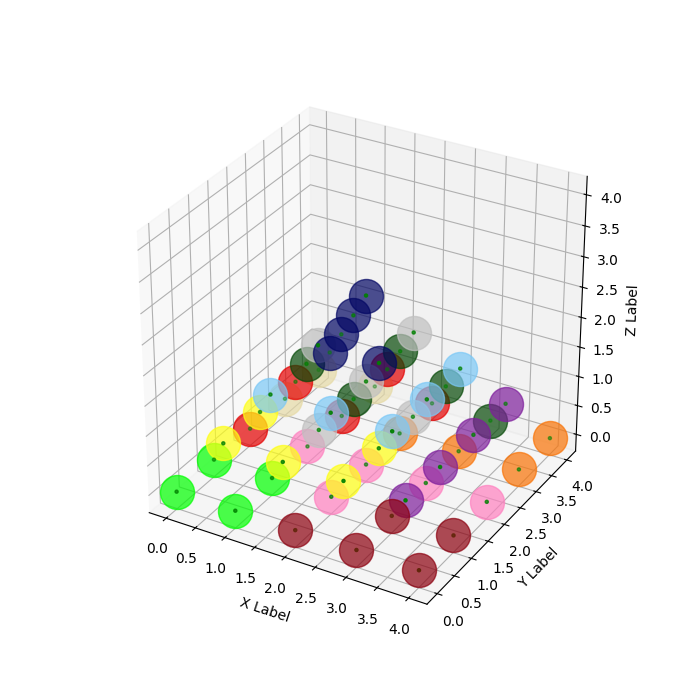

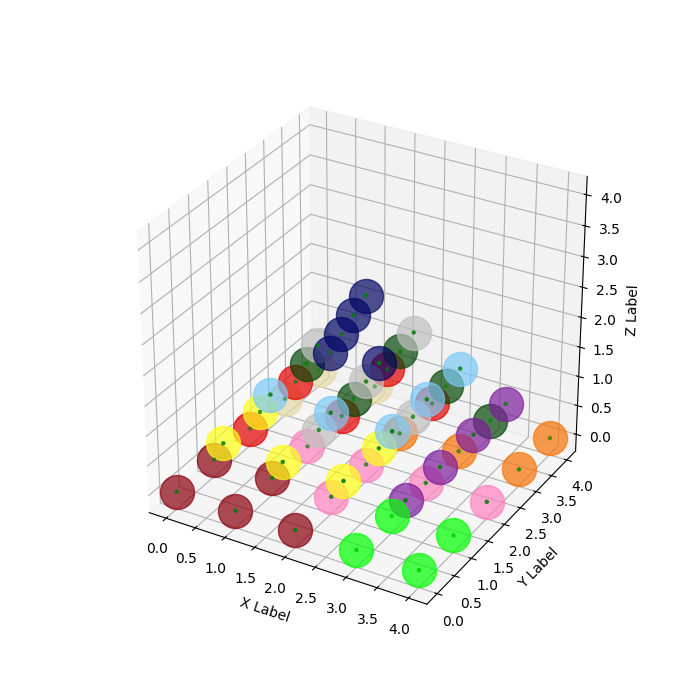

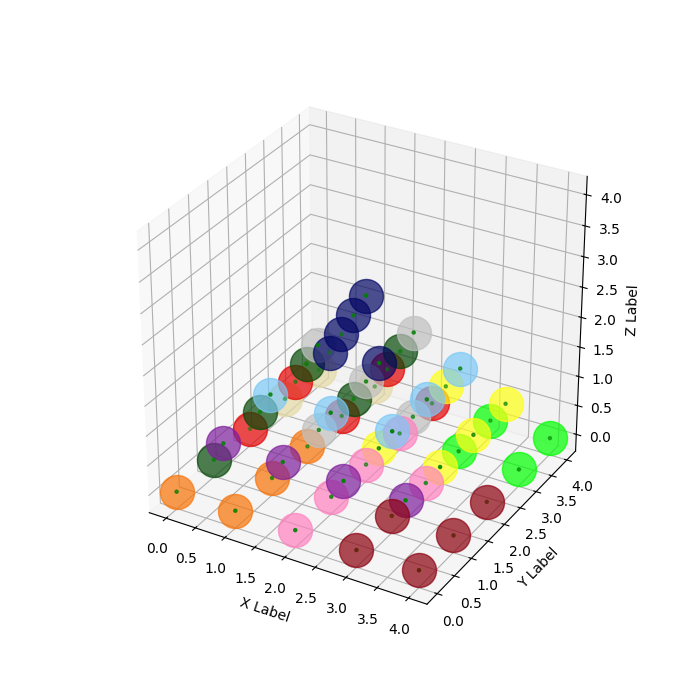

In [4]:
%matplotlib widget
puzzle.visualize(s[0])
puzzle.visualize(s[1])
puzzle.visualize(s[2])

In [5]:
%%time
puzzle=RectanglePuzzle()
s= puzzle.solve(1000)

generated 8 rotations
number of oriented, positioned shapes (cover candidates): 1789
number of solutions: 1000
CPU times: user 4.5 s, sys: 10.6 ms, total: 4.51 s
Wall time: 3.93 s


(Side note: I get 1789 oriented positions contained within the board, but the AMS article claims 2222.  I don't know where the difference lies.  The original article doesn't include the code which generated the positions.

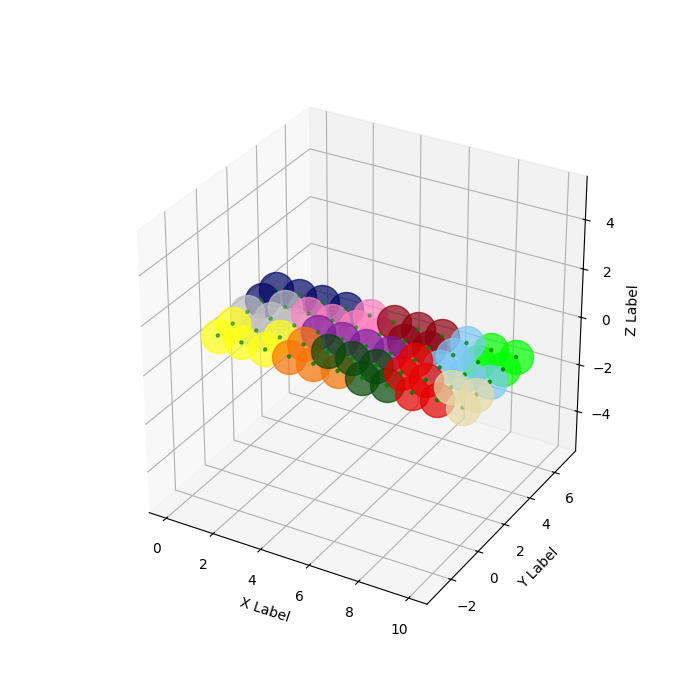

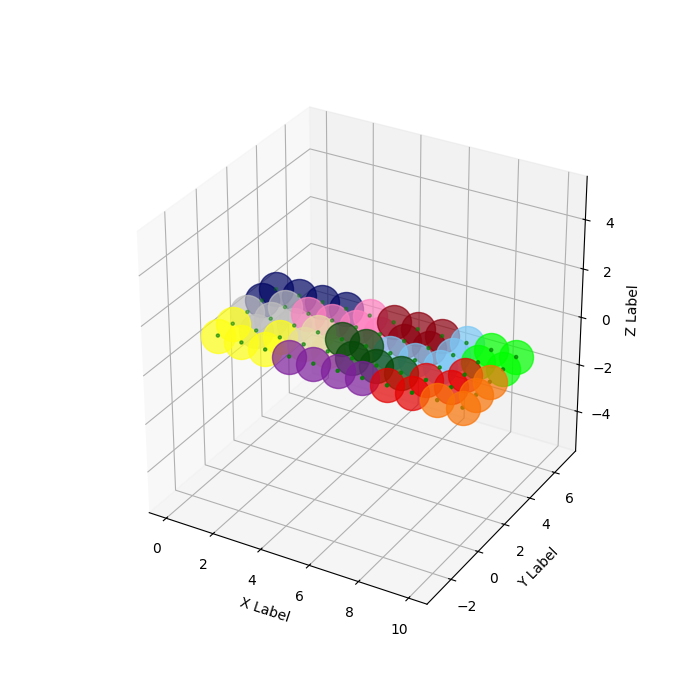

In [6]:
puzzle.visualize(s[0])
puzzle.visualize(s[1])